# Heart Disease EDA and Modeling

This notebook explores `data/heart_disease.csv`, performs cleaning, EDA, and builds a quick baseline model. It will also export cleaned features to aid a later Java-from-scratch implementation.


In [ ]:
# Setup
import sys
from pathlib import Path

NB_DIR = Path.cwd()
PROJECT_ROOT = NB_DIR if (NB_DIR / "data").exists() else NB_DIR.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

DATA_PATH = PROJECT_ROOT / "data" / "heart_disease.csv"

sns.set_theme(style="whitegrid")
RNG = np.random.default_rng(42)


In [2]:
# Load and inspect

df = pd.read_csv(DATA_PATH)
print(f"Rows: {len(df):,}; Columns: {df.shape[1]}")
df.head()


Rows: 10,000; Columns: 21


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,Yes,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,Yes,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,Yes,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,No,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,No,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No


In [10]:
# Inspect schema and missingness

print("Columns:")
print(list(df.columns))
print()
print(df.info())

# Basic missingness summary
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]


Columns:
['age', 'gender', 'blood_pressure', 'cholesterol_level', 'exercise_habits', 'smoking', 'family_heart_disease', 'diabetes', 'bmi', 'high_blood_pressure', 'low_hdl_cholesterol', 'high_ldl_cholesterol', 'alcohol_consumption', 'stress_level', 'sleep_hours', 'sugar_consumption', 'triglyceride_level', 'fasting_blood_sugar', 'crp_level', 'homocysteine_level', 'heart_disease_status']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   9971 non-null   float64
 1   gender                10000 non-null  object 
 2   blood_pressure        9981 non-null   float64
 3   cholesterol_level     9970 non-null   float64
 4   exercise_habits       10000 non-null  object 
 5   smoking               9975 non-null   float64
 6   family_heart_disease  9979 non-null   float64
 7   diabetes              9970 non-null   f

cholesterol_level       30
diabetes                30
age                     29
high_blood_pressure     26
crp_level               26
triglyceride_level      26
high_ldl_cholesterol    26
sleep_hours             25
low_hdl_cholesterol     25
smoking                 25
bmi                     22
fasting_blood_sugar     22
family_heart_disease    21
homocysteine_level      20
blood_pressure          19
dtype: int64

## Data Prep
We have quite a few columns that need to be cleaned and mapped to numerical data types for analysis.

In [20]:
# Clean column names and map types

# Standardize column names: lowercase, snake_case
clean_cols = (
    df.columns
      .str.strip()
      .str.replace("/", "_", regex=False)
      .str.replace(" ", "_", regex=False)
      .str.replace("-", "_", regex=False)
      .str.replace("__+", "_", regex=True)
      .str.lower()
)
rename_map = dict(zip(df.columns, clean_cols))
df = df.rename(columns=rename_map)

# Define groups
bool_like = [
    "smoking", "family_heart_disease", "diabetes",
    "high_blood_pressure", "low_hdl_cholesterol", "high_ldl_cholesterol",
]
ordinal_012 = ["exercise_habits", "stress_level", "sugar_consumption"]  # 0/1/2
alcohol_col = "alcohol_consumption"  # None->0, Low/Medium/High -> 1/2/3
binary_target_col = "heart_disease_status"

# Normalize strings (preserve 'None' for alcohol so we can map it to 0)
for col in df.columns:
    if df[col].dtype == object:
        s = df[col].astype(str).str.strip()
        if col != alcohol_col:
            s = s.replace({"": np.nan, "None": np.nan})
        df[col] = s

# Map boolean-like to 0/1
for col in bool_like:
    if col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], errors="coerce").round().astype("Int64")
        else:
            s = df[col].astype(str).str.lower()
            df[col] = s.map({"yes": 1, "no": 0, "1": 1, "0": 0}).astype("Int64")

# Map ordinals (0/1/2) for exercise_habits, stress_level, sugar_consumption
ord_map_012 = {"low": 0, "medium": 1, "high": 2, "0": 0, "1": 1, "2": 2}
for col in ordinal_012:
    if col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], errors="coerce").round().astype("Int64")
        else:
            s = df[col].astype(str).str.lower()
            df[col] = s.map(ord_map_012).astype("Int64")

# Alcohol consumption: None->0, Low/Medium/High -> 1/2/3
if alcohol_col in df.columns:
    if pd.api.types.is_numeric_dtype(df[alcohol_col]):
        x = pd.to_numeric(df[alcohol_col], errors="coerce").round()
        # If data already 0/1/2/3 keep it, else coerce invalids to NaN
        df[alcohol_col] = x.where(x.isin([0, 1, 2, 3]), other=pd.NA).astype("Int64")
    else:
        s = df[alcohol_col].astype(str).str.strip()
        s_lower = s.str.lower()
        alco_map = {
            "none": 0, "": 0,
            "low": 1, "1": 1,
            "medium": 2, "2": 2,
            "high": 3, "3": 3,
        }
        df[alcohol_col] = s_lower.map(alco_map).astype("Int64")

# Gender: numeric 0/1 where 1.0 is male
if "gender" in df.columns:
    if pd.api.types.is_numeric_dtype(df["gender"]):
        df["gender"] = pd.to_numeric(df["gender"], errors="coerce").round().astype("Int64")
    else:
        s = df["gender"].astype(str).str.strip().str.lower()
        df["gender"] = s.map({"male": 1, "female": 0, "1": 1, "0": 0}).astype("Int64")

# Target: 0 for No, 1 for Yes
if binary_target_col in df.columns:
    if pd.api.types.is_numeric_dtype(df[binary_target_col]):
        df[binary_target_col] = pd.to_numeric(df[binary_target_col], errors="coerce").round().astype("Int64")
    else:
        s = df[binary_target_col].astype(str).str.strip().str.lower()
        df[binary_target_col] = s.map({"yes": 1, "no": 0, "1": 1, "0": 0}).astype("Int64")

print("After cleaning preview:")
df.head()

After cleaning preview:


,age,gender,blood_pressure,cholesterol_level,exercise_habits,smoking,family_heart_disease,diabetes,bmi,high_blood_pressure,low_hdl_cholesterol,high_ldl_cholesterol,alcohol_consumption,stress_level,sleep_hours,sugar_consumption,triglyceride_level,fasting_blood_sugar,crp_level,homocysteine_level,heart_disease_status
0,56.0,1,153.0,155.0,2,1,1,0,24.991591,1,1,0,2,1,7.633228,1,342.0,NaN,12.969246,12.387250,0
1,69.0,0,146.0,286.0,2,0,1,1,25.221799,0,1,0,1,2,8.744034,1,133.0,157.0,9.355389,19.298875,0
2,46.0,1,126.0,216.0,0,0,0,0,29.855447,0,1,1,0,0,4.440440,0,393.0,92.0,12.709873,11.230926,0
3,32.0,0,122.0,293.0,2,1,1,0,24.130477,1,0,1,0,2,5.249405,2,293.0,94.0,12.509046,5.961958,0
4,60.0,1,166.0,242.0,0,1,1,1,20.486289,1,0,0,0,2,7.030971,2,263.0,154.0,10.381259,8.153887,0


In [26]:
# Fix alcohol_consumption mapping: None->0, Low/Med/High->1/2/3, no NaNs
col = "alcohol_consumption"
if col in df.columns:
    s = df[col]
    if pd.api.types.is_numeric_dtype(s):
        s = pd.to_numeric(s, errors="coerce")
        uniq = set(s.dropna().unique().tolist())
        # If previously encoded as 0/1/2, shift to 1/2/3
        if len(uniq) > 0 and uniq.issubset({0, 1, 2}):
            s = s + 1
        # Fill any missing (from prior 'None') with 0
        s = s.fillna(0)
        df[col] = s.astype("Int64")
    else:
        t = s.astype(str).str.strip().str.lower()
        df[col] = t.map({
            "none": 0, "": 0,
            "low": 1, "1": 1,
            "medium": 2, "2": 2,
            "high": 3, "3": 3,
        }).fillna(0).astype("Int64")


Numeric columns (count): 21
Categorical columns (count): 0


,count,mean,std,min,25%,50%,75%,max
age,9971.0,49.296259,18.19397,18.0,34.0,49.0,65.0,80.0
gender,9981.0,0.501252,0.500023,0.0,0.0,1.0,1.0,1.0
blood_pressure,9981.0,149.75774,17.572969,120.0,134.0,150.0,165.0,180.0
cholesterol_level,9970.0,225.425577,43.575809,150.0,187.0,226.0,263.0,300.0
exercise_habits,9975.0,1.010125,0.816045,0.0,0.0,1.0,2.0,2.0
smoking,9975.0,0.513584,0.49984,0.0,0.0,1.0,1.0,1.0
family_heart_disease,9979.0,0.498547,0.500023,0.0,0.0,0.0,1.0,1.0
diabetes,9970.0,0.49669,0.500014,0.0,0.0,0.0,1.0,1.0
bmi,9978.0,29.077269,6.307098,18.002837,23.658075,29.079492,34.520015,39.996954
high_blood_pressure,9974.0,0.503509,0.500013,0.0,0.0,1.0,1.0,1.0


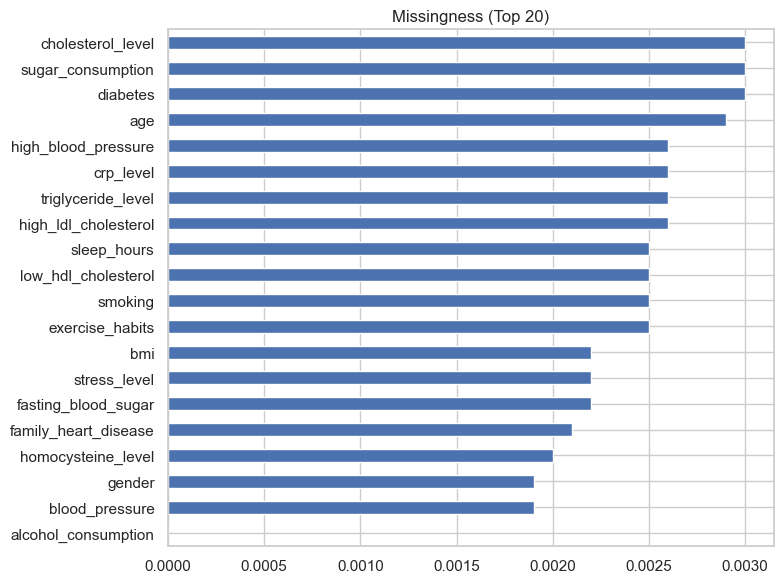

In [27]:


numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in numeric_cols]

print("Numeric columns (count):", len(numeric_cols))
print("Categorical columns (count):", len(cat_cols))

# Summary stats
display(df[numeric_cols].describe().T)

# Missingness bar
missing = df.isna().mean().sort_values(ascending=False)
ax = missing.head(20).plot(kind='barh', figsize=(8,6), title='Missingness (Top 20)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


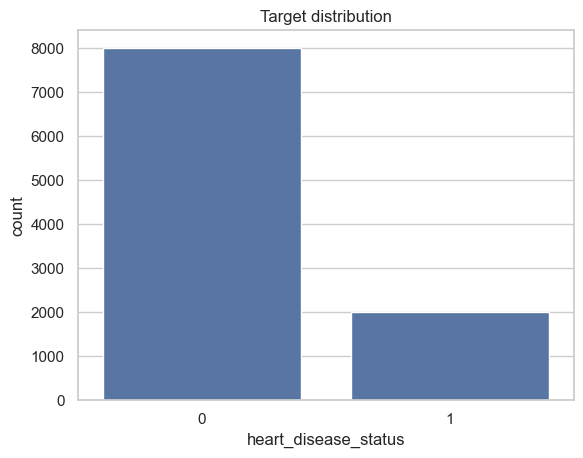

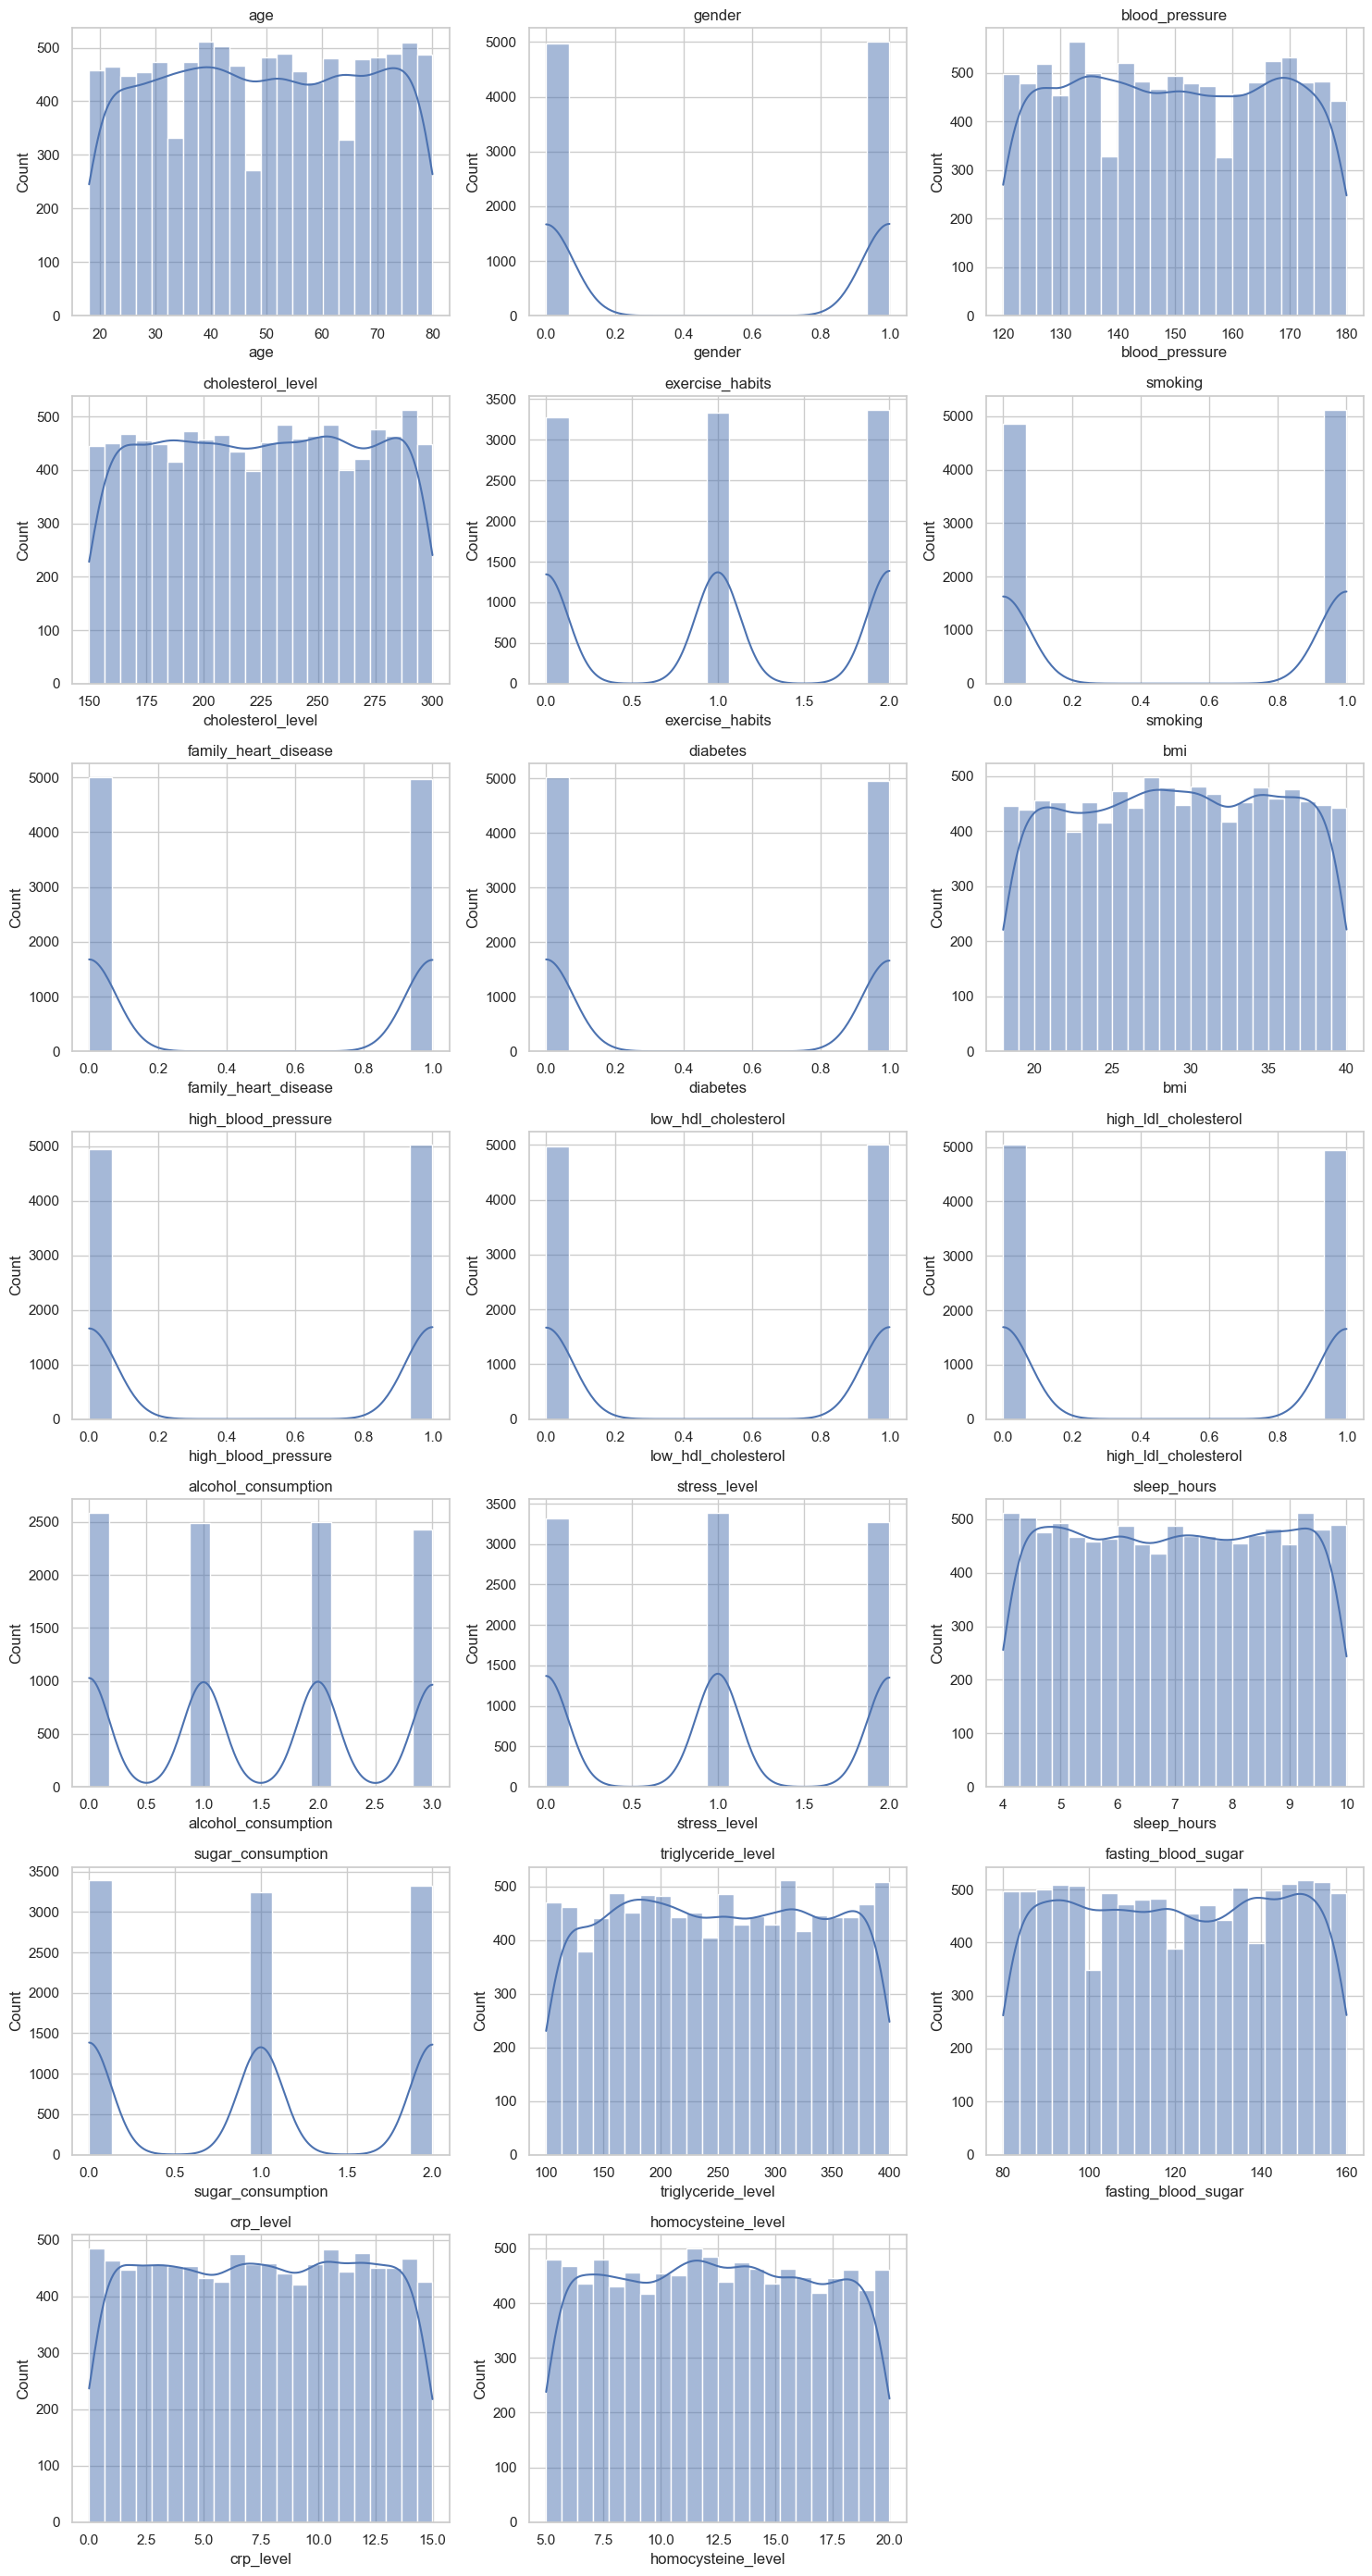

In [28]:
# Distribution plots

TARGET = "heart_disease_status"

# Target distribution
if TARGET in df.columns:
    ax = sns.countplot(data=df, x=TARGET)
    ax.set_title("Target distribution")
    plt.show()

# Numeric distributions (hist + KDE)
num_to_plot = [c for c in numeric_cols if c != TARGET]
fig, axes = plt.subplots(nrows=int(np.ceil(len(num_to_plot)/3)), ncols=3, figsize=(15, 4*int(np.ceil(len(num_to_plot)/3))))
axes = axes.flatten()
for ax, col in zip(axes, num_to_plot):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(col)
for ax in axes[len(num_to_plot):]:
    ax.axis('off')
plt.tight_layout()
plt.show()


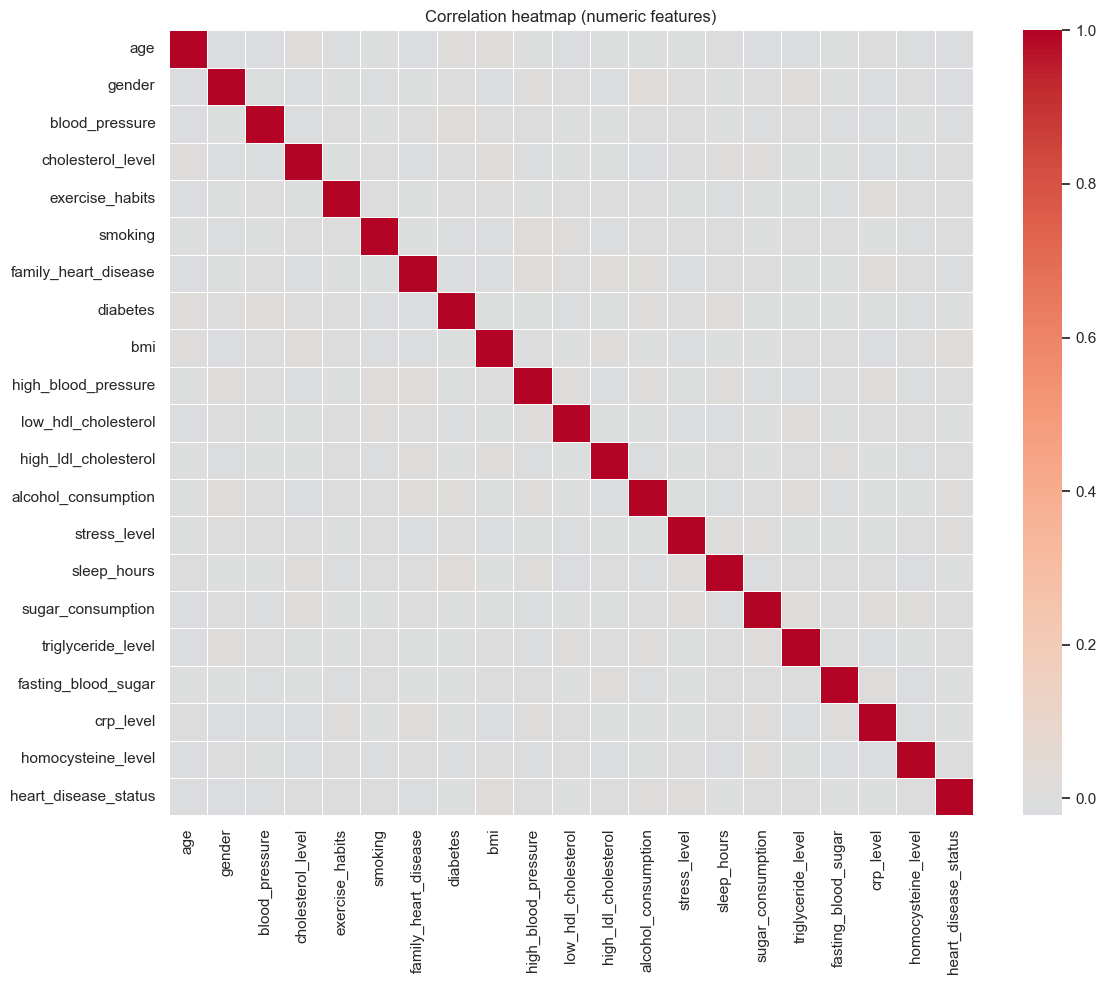

,feature,level,pos_rate
20,stress_level,1,0.214349
18,alcohol_consumption,3,0.209810
24,sugar_consumption,2,0.206006
16,alcohol_consumption,1,0.204180
1,exercise_habits,1,0.203782
14,high_ldl_cholesterol,1,0.203321
5,family_heart_disease,0,0.202438
11,low_hdl_cholesterol,0,0.202412
7,diabetes,0,0.201076
10,high_blood_pressure,1,0.200916


In [30]:
# Correlations and categorical analysis

# Correlation heatmap for numeric features
corr = df[numeric_cols].corr(method='pearson', min_periods=100)
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation heatmap (numeric features)')
plt.tight_layout()
plt.show()

# Category-target rates for boolean/ordinal columns (treat encoded ints as categorical for EDA)
categorical_for_eda = sorted(set(bool_like + list(ordinal_like.keys())))
cat_to_summarize = [c for c in df.columns if c in categorical_for_eda and c != TARGET]
summary_rows = []
for col in cat_to_summarize:
    if df[col].nunique(dropna=True) <= 20:
        rates = df.groupby(col)[TARGET].mean()
        for level, rate in rates.items():
            summary_rows.append({"feature": col, "level": level, "pos_rate": rate})

if summary_rows:
    cat_summary = pd.DataFrame(summary_rows).sort_values("pos_rate", ascending=False)
    display(cat_summary.head(30))
else:
    print("No categorical columns selected for EDA. Adjust 'categorical_for_eda' if needed.")


## TODO

Analysis of this above

In [32]:
# Export cleaned dataset and simple model-ready features (no model object needed)

TARGET = "heart_disease_status"

OUTPUT_DIR = PROJECT_ROOT / "python-analysis" / "artifacts"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Save cleaned dataframe as-is
df.to_csv(OUTPUT_DIR / "heart_disease_cleaned.csv", index=False)

# 2) Build numeric feature matrix and impute missing values
features = [c for c in df.columns if c != TARGET]

# Coerce all features to numeric (non-numeric -> NaN), then median-impute
X_num = df[features].apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X_num), columns=features)

# Append target and save
X_imputed["target"] = y.values
X_imputed.to_csv(OUTPUT_DIR / "features_model_ready.csv", index=False)

print("Saved:")
print(OUTPUT_DIR / "heart_disease_cleaned.csv")
print(OUTPUT_DIR / "features_model_ready.csv")

Saved:
/Users/ogorpynich/heart-disease/python-analysis/artifacts/heart_disease_cleaned.csv
/Users/ogorpynich/heart-disease/python-analysis/artifacts/features_model_ready.csv
